In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
import datasets
import numpy as np

pl.seed_everything(89026614)

text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
#text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

Global seed set to 89026614
Found cached dataset tiny_shakespeare (/Users/cztomsik/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)
100%|██████████| 3/3 [00:00<00:00, 511.77it/s]


In [21]:
device = "mps"
block_size = 256
test_size = 1500
batch_size = 36

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [22]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_layers=3):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
            nn.LayerNorm(embed_dim),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = AFTFull(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )
        self.register_buffer("mask", ~torch.tril(torch.ones(block_size, block_size)).to(bool).to(device))

    def forward(self, x):
        B, T, _ = x.shape
        x = x + self.attn(self.ln1(x), self.mask[:T, :T])
        x = x + self.mlp(self.ln2(x))
        return x

# https://arxiv.org/pdf/2105.14103.pdf
# I am not 100% sure this is correct but it seems to work :shrug:
# unlike with regular attention, we don't need (T, T, C) shape for W, we only need (T, T)
# and those are learned, so we exchange the memory overhead for T^2 extra params per layer
# EDIT: not really, it's now 2T*32 and could be scaled up/down if needed
#       also, the train loss got much better, I have no idea why
class AFTFull(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.uv = nn.Parameter(torch.randn(2, block_size, 32) * 0.01, requires_grad=True)
        self.proj = nn.Linear(embed_dim, embed_dim, bias=False)
    
    def forward(self, x, mask):
        B, T, C = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        w = self.uv[0, :T] @ self.uv[1, :T].T # (T, T)
        w.masked_fill_(mask[:T, :T], float("-Inf"))

        exp_w = w.unsqueeze(0).exp() # (1, T, T)
        exp_k = k.clamp(max=20).exp() # (B, T, C)

        weighted_avg = exp_w @ (exp_k * v) / (exp_w @ exp_k)
        Yt = F.sigmoid(q) * weighted_avg
        return self.proj(Yt)


class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            print(self.generate("And now", 64))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95, last_epoch=-1)
        return [optim], [sched]

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, str, max_new_tokens, top_k=10):
        ids = torch.tensor([dataset.stoi[ch] for ch in str], dtype=torch.long).unsqueeze(0).to(self.device)
        for _ in range(max_new_tokens):
            out = self(ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            ids = torch.cat((ids, step_res), dim=1)
        return "".join([dataset.itos[int(i)] for i in ids[0]])

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=25, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 659 K 
-------------------------------
659 K     Trainable params
0         Non-trainable params
659 K     Total params
2.637     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 30.26it/s]And nowwfXtCwVuRRzEH;$FMPU,;Vu!ewVWyFgB:U3J RCCp.enwfXAsV
OAU,TLotMqMR.
Epoch 0: 100%|██████████| 209/209 [00:10<00:00, 20.26it/s, loss=1.84, v_num=151]And now strer.

CAMILLO:
Mastents, as in I contressalanger:
As it to pu
Epoch 1: 100%|██████████| 209/209 [00:14<00:00, 14.12it/s, loss=1.52, v_num=151, test_loss=1.940]And now, and we have that wast the busince
Were the wittrard, shall thi
Epoch 2: 100%|██████████| 209/209 [00:19<00:00, 10.50it/s, loss=1.4, v_num=151, test_loss=1.660] And now, when the cerest that truth them,
If it he may have heaven stru
Epoch 3: 100%|██████████| 209/209 [00:20<00:00, 10.29it/s, loss=1.34, v_num=151, test_loss=1.570]And now you not through the both
Betten the births have had this procla
Epoch 4: 100%|██████████| 209/209 [00:19<00:00, 10.95it/s, loss=1.3, v_num=151, test_loss=1.500] And now that I will not see them.

ROMEO:
Thou she shall I am lie.

LUC
Epoch 5: 100%|██████████|

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 209/209 [00:19<00:00, 10.87it/s, loss=0.961, v_num=151, test_loss=1.500]


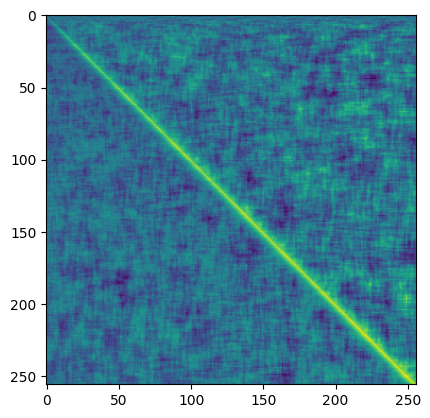

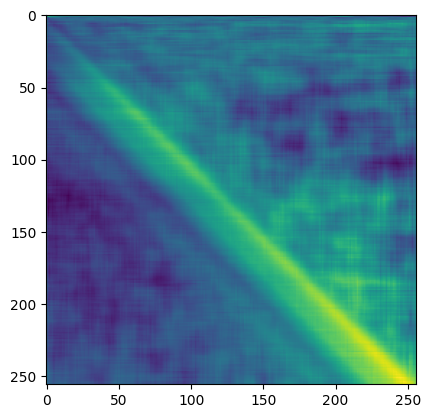

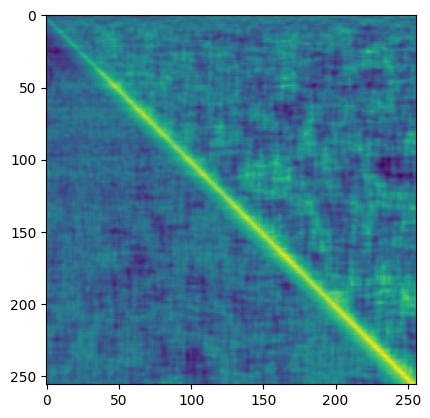

In [23]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow((b.attn.uv[0] @ b.attn.uv[1].T).detach().numpy())

In [24]:
print(model.generate("O God, O God!", 1024))

O God, O God! truly fellow with that wats:
'Tis sure of years and sun, as if I am divine.
Nay! What, I am to the two?

CATESBY:
What, may say I am, God to bend my death,
Near to thy swords to thy father and my son,
And say yield me to my charge fretting insolent:
Believe's my son is to death, so words are plain,
Were the thiin a fruit-leam-Erkeing barbed their faces.
Send thy deed left the worst of thine ears!
Bear my ghostly not won I would not kill.

KING RICHARD II:
Stand to the army, let us being been;
Take the thought of all hers. My part sit was
Which we have thought to thee, ha?end hook! Where is my letters;
But swill you stay, so happy by you;
Which eloquent will got a proud to bed.
What! Ostrain, my great play-glass! You speak o' the gods
More that is in all allegiance of your hands
To be acquainted: so upon this friends are so absent,
Tell me, what you will won one happy brother?

CAMILLO:
Beseech you, sir,
You shall have a soldier is too groan!

FLORIZEL:
Content:
It won we 